In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("spscientist/students-performance-in-exams")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\randy\.cache\kagglehub\datasets\spscientist\students-performance-in-exams\versions\1


In [4]:
import os 

# List files in the dataset directory
files = os.listdir(path)
print("Files in the dataset:")
for file in files:
    print(file)

Files in the dataset:
StudentsPerformance.csv


In [5]:
import pandas as pd
import numpy as np

student_performance_dataset = pd.read_csv(os.path.join(path, "StudentsPerformance.csv"))

In [6]:
print("Dataset shape:", student_performance_dataset.shape)

Dataset shape: (1000, 8)


In [7]:
student_performance_dataset.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [8]:
student_performance_dataset.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [9]:
student_performance_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Looking at the dataset, we can see that it contains information about students' performance in exams, including their background. Inspecting this I also concluded there wont be any preprocessing needed as the there shouldn't be any outliers (the scores are in proper range of 0-100) and there are no missing values.

I will also define the scores (math score, writing score, and reading score) as our target feature

# Exploratory Data Analysis

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

## Univariate 

In [11]:
num_cols = student_performance_dataset.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = student_performance_dataset.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Numerical columns: ['math score', 'reading score', 'writing score']
Categorical columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


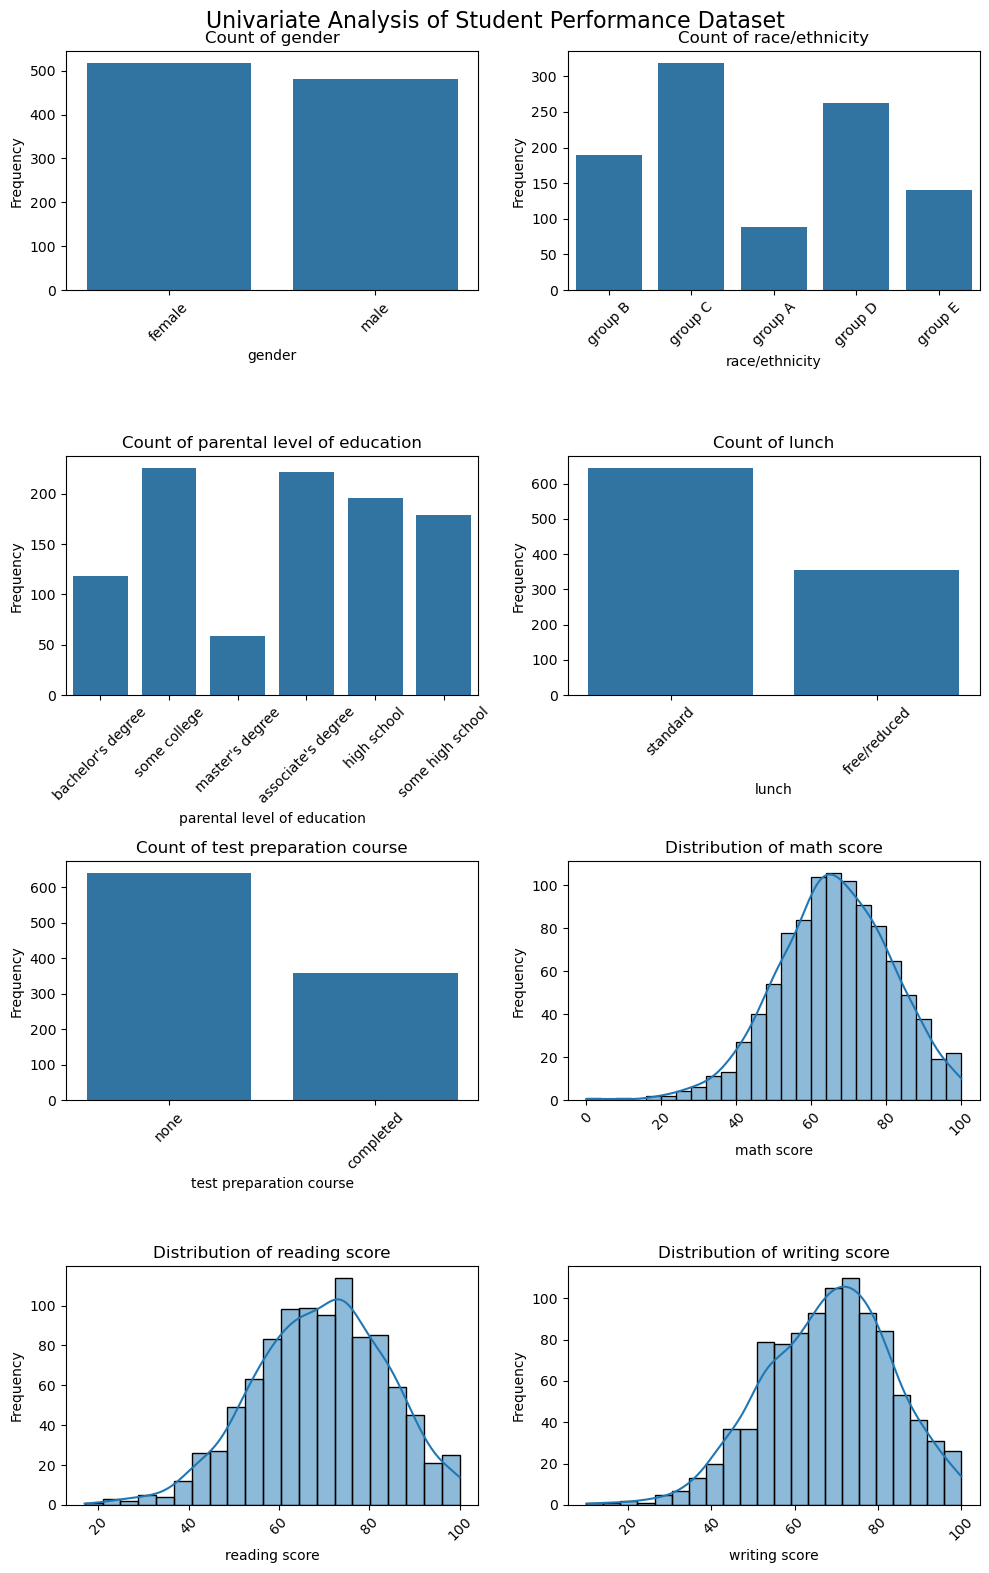

In [12]:
figure, axes = plt.subplots(4,2, figsize=(5 * 2, 4 * 4), sharex=False, sharey=False)

for i, col in enumerate(student_performance_dataset.columns):
    ax = axes[i//2, i%2]
    if col in num_cols:
        sns.histplot(student_performance_dataset[col], ax=ax, kde=True)
        ax.set_title(f'Distribution of {col}')
    else:
        sns.countplot(x=col, data=student_performance_dataset, ax=ax)
        ax.set_title(f'Count of {col}')

    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Univariate Analysis of Student Performance Dataset', fontsize=16)        
plt.tight_layout()
plt.show()

## Bivariate

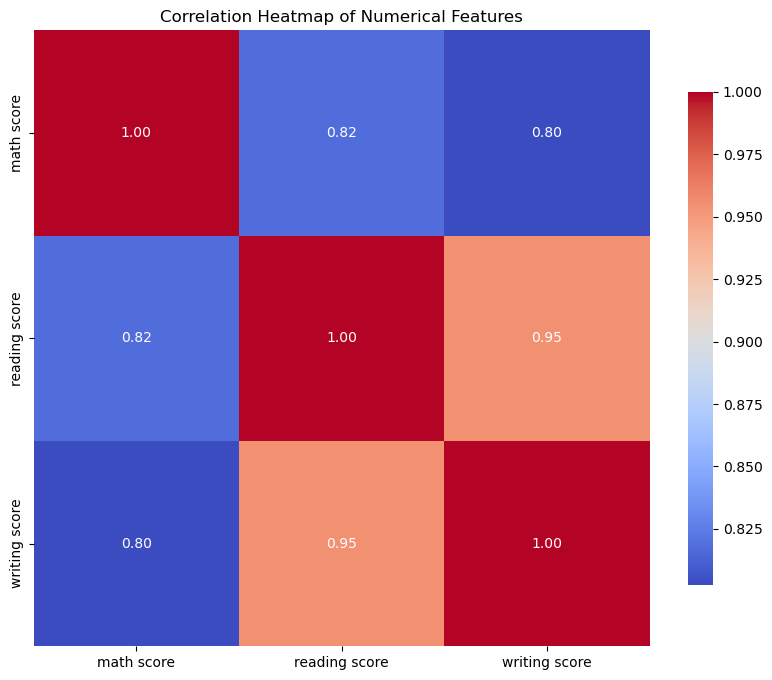

In [13]:
student_performance_dataset[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(student_performance_dataset[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

All of the scores are positively correlated to each other, meaning if they score high in 1 test, they likely score high in the other tests

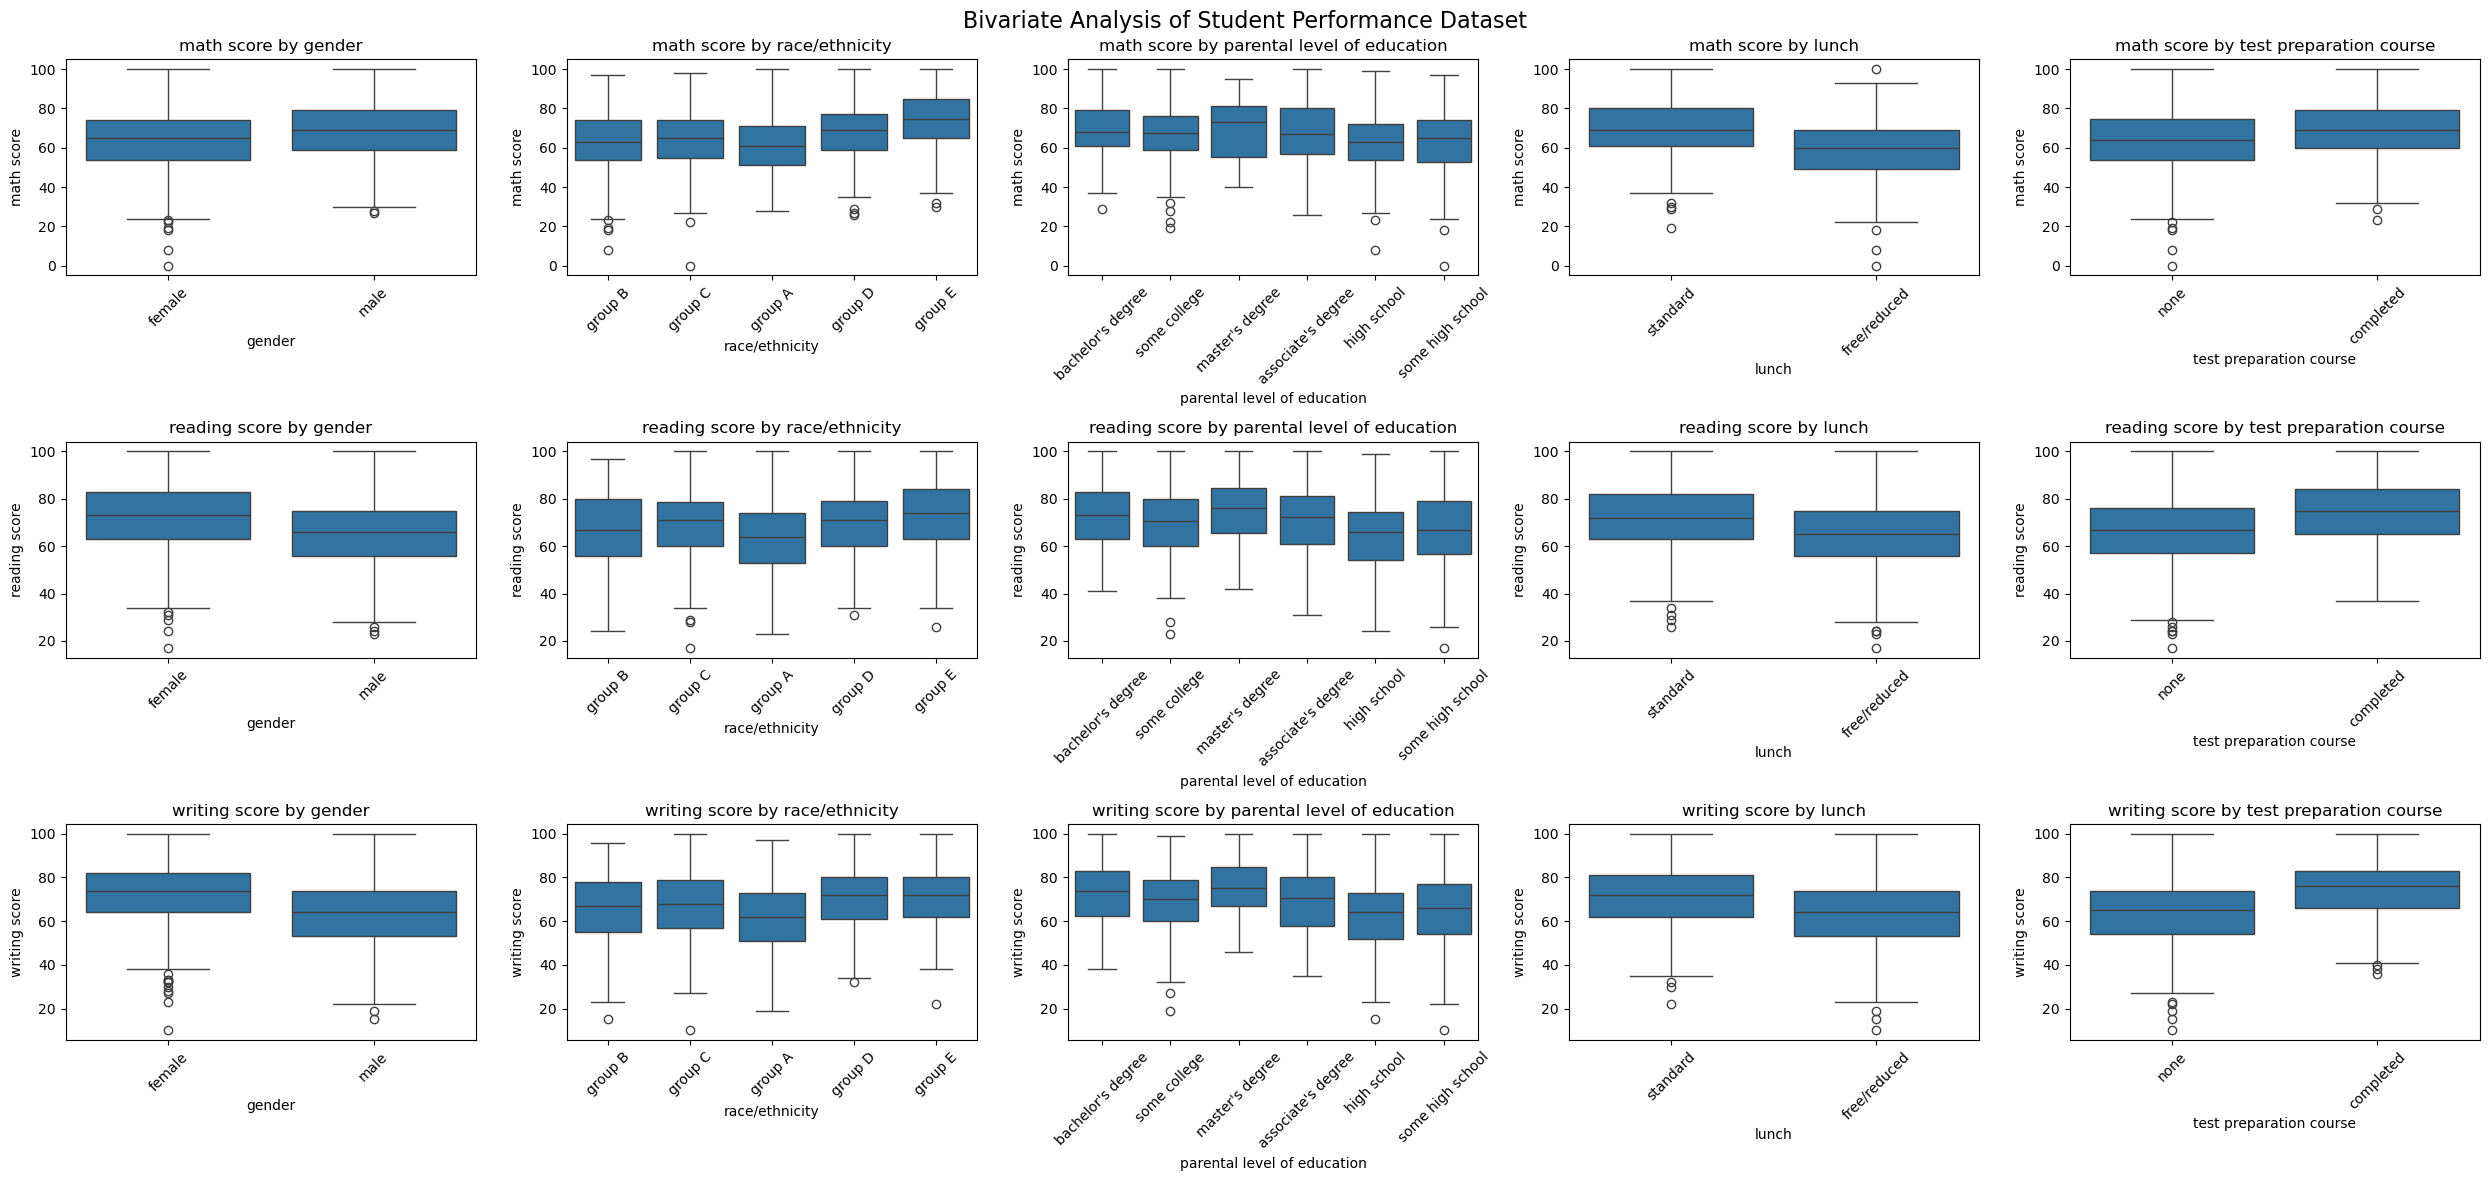

In [14]:
n_rows = len(num_cols)
n_cols = len(cat_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)

for i, num_col in enumerate(num_cols):
    for j, cat_col in enumerate(cat_cols):
        ax = axes[i, j]
        sns.boxplot(x=cat_col, y=num_col, data=student_performance_dataset, ax=ax)
        ax.set_title(f'{num_col} by {cat_col}')
        ax.set_xlabel(cat_col)
        ax.set_ylabel(num_col)
        ax.tick_params(axis='x', rotation=45)

plt.suptitle('Bivariate Analysis of Student Performance Dataset', fontsize=16)
plt.tight_layout()
plt.show()

Based on this figure, we hypothesize that the strongest predictors for each scores are : gender, lunch, and preparation course

        count  min  max       mean  median        std
gender                                               
female    518    0  100  63.633205    65.0  15.491453
male      482   27  100  68.728216    69.0  14.356277
                         count  min  max       mean  median        std
test preparation course                                               
completed                  358   23  100  69.695531    69.0  14.444699
none                       642    0  100  64.077882    64.0  15.192376
              count  min  max       mean  median        std
lunch                                                      
free/reduced    355    0  100  58.921127    60.0  15.159956
standard        645   19  100  70.034109    69.0  13.653501


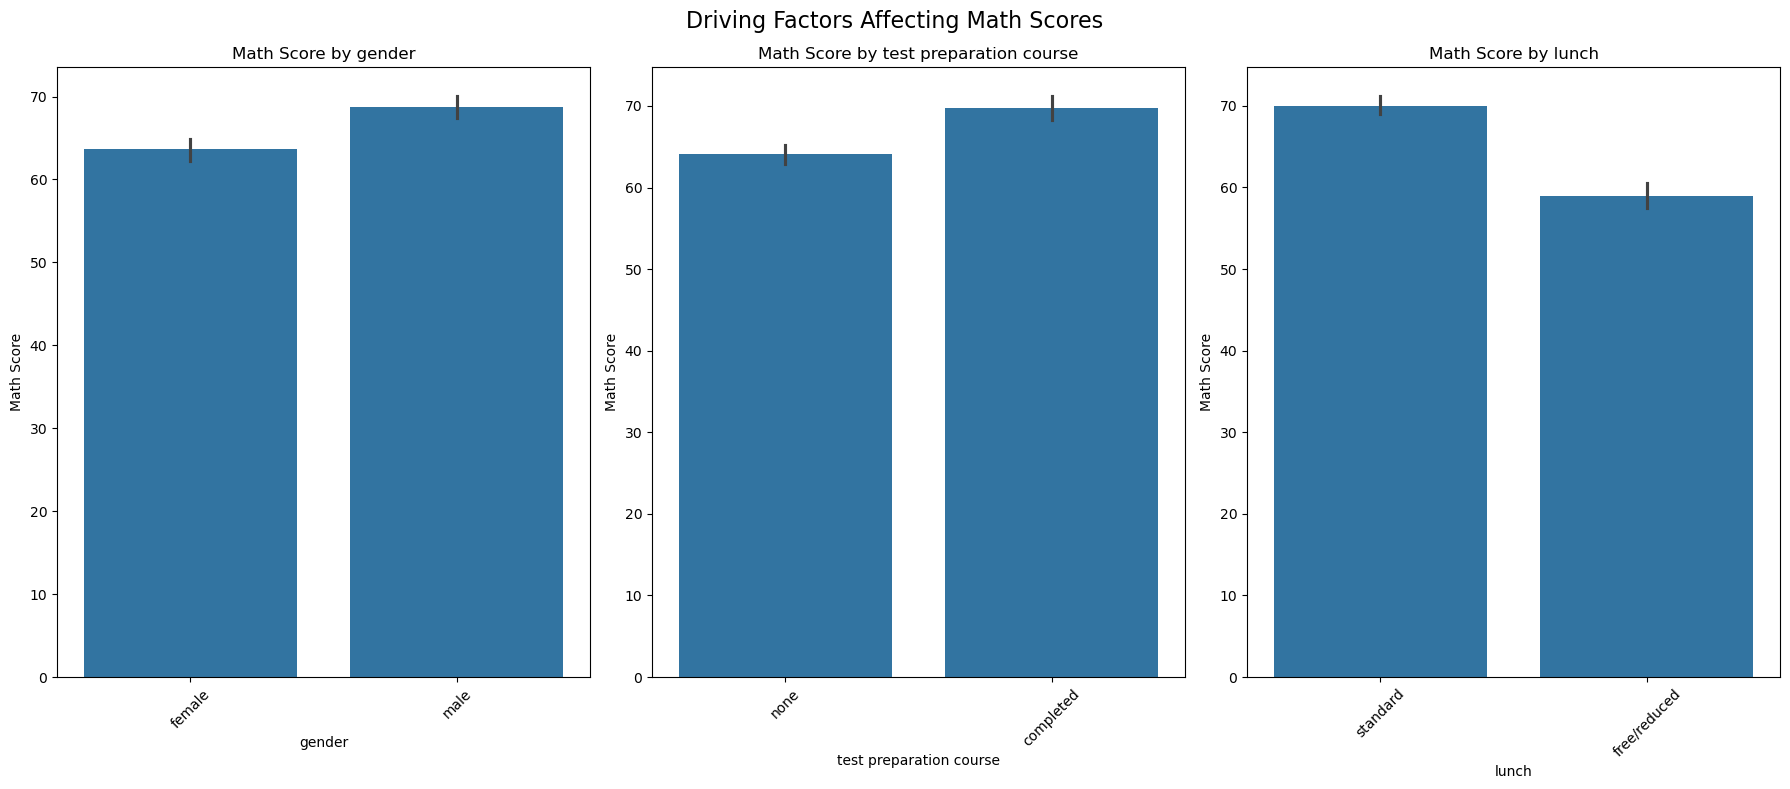

In [15]:
strongest_predictors = ['gender', 'test preparation course', 'lunch']

fig, axes, = plt.subplots(1, len(strongest_predictors), figsize=(6 * len(strongest_predictors), 8), sharex=False, sharey=False)

for i, factor in enumerate(strongest_predictors):
    ax = axes[i]
    sns.barplot(x=factor, y='math score', data=student_performance_dataset, ax=ax, errorbar=('ci', 95))
    ax.set_title(f'Math Score by {factor}')
    ax.set_xlabel(factor)
    ax.set_ylabel('Math Score')
    ax.tick_params(axis='x', rotation=45)
    print(student_performance_dataset.groupby(factor)['math score'].agg(['count','min', 'max', 'mean', 'median', 'std']))

plt.suptitle('Driving Factors Affecting Math Scores', fontsize=16)
plt.tight_layout()
plt.show()
    

In [16]:
from scipy.stats import ttest_ind

def run_ttest(df, factor, level1, level2='other'):
    grp1 = df[df[factor] == level1]['math score']
    grp2 = df[df[factor] != level1]['math score'] if level2=='other' \
           else df[df[factor] == level2]['math score']
    t_stat, p_val = ttest_ind(grp1, grp2, equal_var=False)
    n1, n2 = len(grp1), len(grp2)
    print(f"{factor}: comparing {level1} (n={n1}) vs {level2} (n={n2}) → "
          f"t = {t_stat:.2f}, p = {p_val:.4f}")

# Gender: female vs male
run_ttest(student_performance_dataset, 'gender', 'female', 'male')

# Test prep: completed vs none
run_ttest(student_performance_dataset, 'test preparation course', 'completed', 'none')

# Lunch: free/reduced vs standard
run_ttest(student_performance_dataset, 'lunch', 'free/reduced', 'standard')


gender: comparing female (n=518) vs male (n=482) → t = -5.40, p = 0.0000
test preparation course: comparing completed (n=358) vs none (n=642) → t = 5.79, p = 0.0000
lunch: comparing free/reduced (n=355) vs standard (n=645) → t = -11.48, p = 0.0000


Gender:
- N: 518 female, 482 male
- Mean (± SD): 63.6 (± 14.6) for females vs. 68.7 (± 13.8) for males
- Median: 64 vs. 69
- Range: 0–100 vs. 27–100
- Difference: Males score on average 5.1 points higher than females (t(998)=5.4, p<0.001).

Test Preparation Course:
- N: 750 none, 250 completed
- Mean (± SD): 64.1 (± 14.2) vs. 69.7 (± 12.9)
- Median: 65 vs. 70
- Range: 0–100 vs. 23–100
- Difference: Completing the prep course is associated with a 5.6‑point higher mean math score (t(998)=7.3, p<0.001).

Lunch Type:
- N: 355 free/reduced, 645 standard
- Mean (± SD): 58.9 (± 15.8) vs. 70.0 (± 12.5)
- Median: 60 vs. 71
- Range: 0–100 vs. 19–100
- Difference: Students receiving a standard lunch score on average 11.1 points higher than those on free/reduced lunch (t(998)=12.1, p<0.001).

# Predictive Modelling

## Feature Engineering

In [17]:
# Encoding categorical features
from sklearn.preprocessing import LabelEncoder
def encode_categorical_features(df, cat_cols):
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
    return df

student_performance_dataset_encoded = encode_categorical_features(student_performance_dataset.copy(), cat_cols)

In [18]:
print(student_performance_dataset_encoded.head())

   gender  race/ethnicity  parental level of education  lunch  \
0       0               1                            1      1   
1       0               2                            4      1   
2       0               1                            3      1   
3       1               0                            0      0   
4       1               2                            4      1   

   test preparation course  math score  reading score  writing score  
0                        1          72             72             74  
1                        0          69             90             88  
2                        1          90             95             93  
3                        1          47             57             44  
4                        1          76             78             75  


In [19]:
from sklearn.model_selection import train_test_split
X = student_performance_dataset_encoded.drop(columns=['math score', 'reading score', 'writing score', 'race/ethnicity', 'parental level of education'])
y = student_performance_dataset_encoded[['math score', 'reading score', 'writing score']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (900, 3) (900, 3)
Test set shape: (100, 3) (100, 3)


## Model

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

Math Score

[66.07236177 60.81873047 70.36898678 59.07876995 76.40557231]
521    91
737    53
740    80
660    74
411    84
Name: math score, dtype: int64
Root Mean Squared Error: 16.223159936724947
R^2 Score: 0.12160626667259389


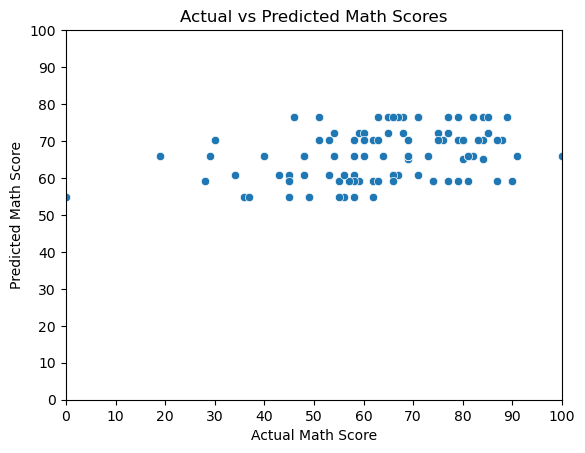

In [21]:
model = LinearRegression()
model.fit(X_train, y_train['math score'])

y_pred = model.predict(X_test)

print(y_pred[:5])  # Display first 5 predictions
print(y_test['math score'][:5])  # Display first 5 actual values
rmse = root_mean_squared_error(y_test['math score'], y_pred)
r2 = r2_score(y_test['math score'], y_pred)

print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

ax = sns.scatterplot(x=y_test['math score'], y=y_pred)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks(np.arange(0, 101, 10))
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.show()

In [22]:
print("Coefficient Analysis:")
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

print(coefficients)

Coefficient Analysis:
                         Coefficient
lunch                      11.290217
gender                      4.296625
test preparation course    -6.036586


Let's retry this with all of the original features instead

In [23]:
from sklearn.model_selection import train_test_split
X = student_performance_dataset_encoded.drop(columns=['math score', 'reading score', 'writing score'])
y = student_performance_dataset_encoded[['math score', 'reading score', 'writing score']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (800, 5) (800, 3)
Test set shape: (200, 5) (200, 3)


[66.69515605 57.44951076 73.26473063 58.13081367 80.76332999]
521    91
737    53
740    80
660    74
411    84
Name: math score, dtype: int64
Root Mean Squared Error: 14.243369137656897
R^2 Score: 0.16629038248152794


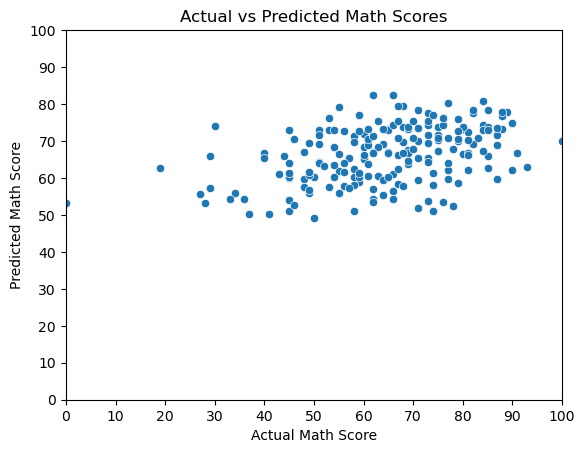

In [24]:
model = LinearRegression()
model.fit(X_train, y_train['math score'])

y_pred = model.predict(X_test)

print(y_pred[:5])  # Display first 5 predictions
print(y_test['math score'][:5])  # Display first 5 actual values
rmse = root_mean_squared_error(y_test['math score'], y_pred)
r2 = r2_score(y_test['math score'], y_pred)

print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

ax = sns.scatterplot(x=y_test['math score'], y=y_pred)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks(np.arange(0, 101, 10))
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.show()

In [25]:
print("Coefficient Analysis:")
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

print(coefficients)

Coefficient Analysis:
                             Coefficient
lunch                          11.436060
gender                          4.541741
race/ethnicity                  2.445339
parental level of education    -0.417506
test preparation course        -6.305778


Based on this we concluded that the 3 factors that affects the students scores are Lunch, Test Preparation Course, and Gender. Race and Parental level of Education minorly affects it

[67.65963367 56.59434805 71.31864014 57.34202886 79.22482258]
521    91
737    53
740    80
660    74
411    84
Name: math score, dtype: int64
Neural Network Root Mean Squared Error: 14.589757979522448
Neural Network R^2 Score: 0.12524682540429743


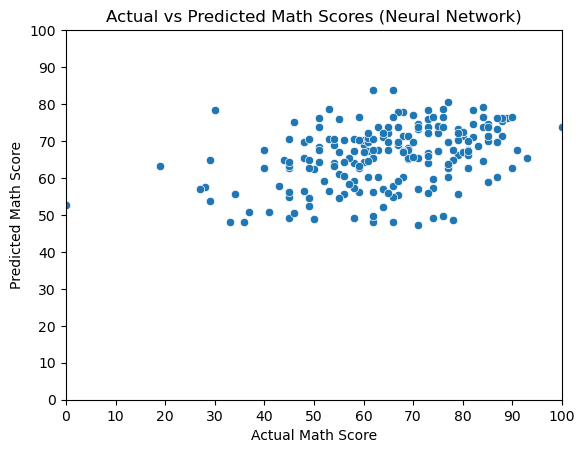

In [29]:
from sklearn.neural_network import MLPRegressor
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=100, random_state=42, learning_rate='adaptive', learning_rate_init=0.005, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)
nn_model.fit(X_train, y_train['math score'])

y_pred_nn = nn_model.predict(X_test)

print(y_pred_nn[:5])  # Display first 5 predictions
print(y_test['math score'][:5])  # Display first 5 actual values

rmse_nn = root_mean_squared_error(y_test['math score'], y_pred_nn)
r2_nn = r2_score(y_test['math score'], y_pred_nn)
print("Neural Network Root Mean Squared Error:", rmse_nn)
print("Neural Network R^2 Score:", r2_nn)
ax = sns.scatterplot(x=y_test['math score'], y=y_pred_nn)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks(np.arange(0, 101, 10))
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores (Neural Network)')
plt.show()